In [1]:
pip install accelerate -U

In [2]:
!pip install sentencepiece

  Using cached sentencepiece-0.1.99-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [3]:
pip install transformers

  Using cached transformers-4.35.0-py3-none-any.whl (7.9 MB)
  Using cached tokenizers-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [4]:
# import the necessary libraries
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import torch.nn as nn
import transformers
from torch.utils.data import DataLoader, TensorDataset

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Load data from .npy file
data = np.load("/content/gdrive/MyDrive/sentence_puzzle.npy", allow_pickle=True)[()]

In [7]:
import json

# Define the path to your JSONL file
jsonl_file_path = '/content/gdrive/MyDrive/csqa_train.jsonl'

# Initialize an empty list to store the parsed JSON data
cs_data = []

# Read the JSONL file line by line and parse each line as JSON
with open(jsonl_file_path, 'r') as file:
    for line in file:
        cs_data.append(json.loads(line))

FileNotFoundError: ignored

In [ ]:
test_q = [entry['question'] for entry in cs_data]
# options = [entry['choice_list'] for entry in training_data]
corr_q = [entry['answerKey'] for entry in cs_data]

In [ ]:
corr_q[]

In [ ]:
df=pd.DataFrame(cs_data)
df

In [8]:
import numpy as np
import torch

seed = 42  # You can choose any seed value
np.random.seed(seed)
torch.manual_seed(seed)

In [9]:
# Split data into training and validation
split_ratio = 0.8

total_samples = len(data)
split_index = int(total_samples * split_ratio)

training_data = data[:split_index]
validation_data = data[split_index:]

# Extract questions, options, and correct_indices for training and validation sets
questions = [entry['question'] for entry in training_data]
options = [entry['choice_list'] for entry in training_data]
correct_indices = [entry['label'] for entry in training_data]

validation_questions = [entry['question'] for entry in validation_data]
validation_options = [entry['choice_list'] for entry in validation_data]
validation_correct_indices = [entry['label'] for entry in validation_data]

In [10]:
df = pd.DataFrame(training_data)
df

,0
0,"{'id': 'SP-0', 'question': 'Mr. and Mrs. Musta..."
1,"{'id': 'SP-0_SR', 'question': 'The six daughte..."
2,"{'id': 'SP-0_CR', 'question': 'A chess team ha..."
3,"{'id': 'SP-1', 'question': 'A woman shoots her..."
4,"{'id': 'SP-1_SR', 'question': 'An individual s..."
...,...
496,"{'id': 'SP-165_SR', 'question': 'Cleopatra and..."
497,"{'id': 'SP-165_CR', 'question': 'Two chickens ..."
498,"{'id': 'SP-166', 'question': 'A man has 9 chil..."
499,"{'id': 'SP-166_SR', 'question': 'A man has nin..."


In [11]:
print(questions[1])
print(options[1])
print(correct_indices[1])

The six daughters of Mr. and Mrs. Mustard each have one brother. However, the family only consists of nine people; how is that possible?
['Some brothers were not loved by family and moved away.', 'Each daughter shares the same brother.', 'Some daughters get married and have their own family.', 'None of above.']
1


In [12]:
len(training_data)

501

In [13]:
from transformers import XLNetForMultipleChoice, XLNetTokenizer

model_name = "xlnet-base-cased"  # Choose the specific variant you need
model = XLNetForMultipleChoice.from_pretrained(model_name)
tokenizer = XLNetTokenizer.from_pretrained(model_name)

Some weights of XLNetForMultipleChoice were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import AutoTokenizer
import numpy as np

# Tokenize questions and options for training set
tokenized_training_data = []
for i in range(len(questions)):
    choices = options[i]
    input_ids = []
    attention_mask = []

    for choice in choices:
        # Combine the question and choice
        text = questions[i] + " " + choice

        # Tokenize and encode the text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

        input_ids.append(inputs['input_ids'])
        attention_mask.append(inputs['attention_mask'])

    tokenized_training_data.append({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'correct_index': correct_indices[i]
    })

# Tokenize questions and options for validation set
tokenized_validation_data = []
for i in range(len(validation_questions)):
    choices = validation_options[i]
    input_ids = []
    attention_mask = []

    for choice in choices:
        # Combine the question and choice
        text = validation_questions[i] + " " + choice

        # Tokenize and encode the text
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

        input_ids.append(inputs['input_ids'])
        attention_mask.append(inputs['attention_mask'])

    tokenized_validation_data.append({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'correct_index': validation_correct_indices[i]
    })

# Save tokenized data as numpy arrays
np.save('tokenized_training_data.npy', tokenized_training_data)
np.save('tokenized_validation_data.npy', tokenized_validation_data)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [15]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch
import numpy as np

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        # Extract questions, options, and correct indices
        input_ids = np.array([feature["input_ids"] for feature in features])
        attention_mask = np.array([feature["attention_mask"] for feature in features])
        labels = np.array([feature["correct_index"] for feature in features])

        batch_size = len(input_ids)
        num_choices = input_ids.shape[1]

        # Flatten features
        flattened_features = {
            "input_ids": input_ids.reshape(batch_size * num_choices, -1),
            "attention_mask": attention_mask.reshape(batch_size * num_choices, -1),
        }

        # Pad and reshape
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # Reshape the batch
        batch = {
            k: v.view(batch_size, num_choices, -1) for k, v in batch.items()
        }
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [16]:
from transformers import AutoTokenizer

# Tokenize questions and options for training set
tokenized_training_data = []
max_sequence_length = 128  # Define your desired sequence length

for i in range(len(questions)):
    choices = options[i]
    input_ids = []
    attention_mask = []

    for choice in choices:
        # Combine the question and choice
        text = questions[i] + " " + choice

        # Tokenize and encode the text with padding and truncation
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',  # Pad to the specified sequence length
            truncation=True,
            max_length=max_sequence_length,
        )

        input_ids.append(inputs['input_ids'])
        attention_mask.append(inputs['attention_mask'])

    tokenized_training_data.append({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'correct_index': correct_indices[i]
    })

# Tokenize questions and options for validation set
tokenized_validation_data = []
for i in range(len(validation_questions)):
    choices = validation_options[i]
    input_ids = []
    attention_mask = []

    for choice in choices:
        # Combine the question and choice
        text = validation_questions[i] + " " + choice

        # Tokenize and encode the text with padding and truncation
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',  # Pad to the specified sequence length
            truncation=True,
            max_length=max_sequence_length,
        )

        input_ids.append(inputs['input_ids'])
        attention_mask.append(inputs['attention_mask'])

    tokenized_validation_data.append({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'correct_index': validation_correct_indices[i]
    })

# Save tokenized data as numpy arrays
np.save('tokenized_training_data.npy', tokenized_training_data)
np.save('tokenized_validation_data.npy', tokenized_validation_data)

In [17]:
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.data.data_collator import DataCollatorWithPadding

# Load your tokenized training and validation data
tokenized_training_data = np.load('tokenized_training_data.npy', allow_pickle=True)
tokenized_validation_data = np.load('tokenized_validation_data.npy', allow_pickle=True)

# Define a custom dataset class for multiple-choice questions
class MultipleChoiceDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.data[idx]['input_ids'],
            'attention_mask': self.data[idx]['attention_mask'],
            'labels': self.data[idx]['correct_index']
        }

# Create DataLoader for training and validation
batch_size = 16  # Adjust as needed
train_dataset = MultipleChoiceDataset(tokenized_training_data)
train_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

validation_dataset = MultipleChoiceDataset(tokenized_validation_data)
validation_data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir="fine_tune_xlnet",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,  # Set to True if you want to push the model to the Hugging Face Model Hub
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=train_data_collator,  # Use the data collator for training
    train_dataset=train_dataset,  # Use the dataset for training
    eval_dataset=validation_dataset,  # Use the dataset for validation
    tokenizer=tokenizer,
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.020891
2,No log,0.789511
3,No log,0.820572


TrainOutput(global_step=96, training_loss=0.5022457440694174, metrics={'train_runtime': 206.9062, 'train_samples_per_second': 7.264, 'train_steps_per_second': 0.464, 'total_flos': 428171509527552.0, 'train_loss': 0.5022457440694174, 'epoch': 3.0})

In [18]:
pip install huggingface_hub

In [19]:
from huggingface_hub import notebook_login

notebook_login()

In [20]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1699267757.e2a904b2d9ea.664.0:   0%|          | 0.00/5.60k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

'https://huggingface.co/yashikam19/fine_tune_xlnet/tree/main/'

In [21]:
from transformers import AutoTokenizer, AutoModelForMultipleChoice

In [22]:
model = AutoModelForMultipleChoice.from_pretrained("fine_tune_xlnet")

In [23]:
tokenizer = AutoTokenizer.from_pretrained("fine_tune_xlnet")

In [24]:
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: value.to(model.device) for key, value in batch.items()}
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels).item()
            total += len(labels)
    return correct / total

In [26]:
from torch.utils.data import DataLoader

# Define your batch size
batch_size = 16  # Adjust according to your needs

# Create a DataLoader for the validation dataset
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    collate_fn=validation_data_collator,

)

In [ ]:
from torch.utils.data import DataLoader

# Define your batch size
batch_size = 16  # Adjust according to your needs

# Create a DataLoader for the validation dataset
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    collate_fn=validation_data_collator,

)

# Calculate validation accuracy
validation_accuracy = calculate_accuracy(model, validation_dataloader)
print(f"Validation Accuracy: {validation_accuracy:.2%}")

In [ ]:
import random

# Define a seed for reproducibility
seed = 42
random.seed(seed)

shuffled_validation_options = []
shuffled_validation_correct_indices = []

for options, correct_index in zip(validation_options, validation_correct_indices):
    # Create a list of indices to shuffle
    indices = list(range(len(options)))
    random.shuffle(indices)

    # Shuffle options and update the correct index
    shuffled_options = [options[i] for i in indices]
    shuffled_correct_index = indices.index(correct_index)

    shuffled_validation_options.append(shuffled_options)
    shuffled_validation_correct_indices.append(shuffled_correct_index)

In [ ]:
# Tokenize questions and options for validation set
shuff_val = []
for i in range(len(validation_questions)):
    choices = shuffled_validation_options[i]
    input_ids = []
    attention_mask = []

    for choice in choices:
        # Combine the question and choice
        text = validation_questions[i] + " " + choice

        # Tokenize and encode the text with padding and truncation
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',  # Pad to the specified sequence length
            truncation=True,
            max_length=max_sequence_length,
        )

        input_ids.append(inputs['input_ids'])
        attention_mask.append(inputs['attention_mask'])

    shuff_val.append({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'correct_index': shuffled_validation_correct_indices[i]
    })

np.save('shuff.npy', shuff_val)

In [ ]:
validation_dataset2 = MultipleChoiceDataset(shuff_val)
validation_data_collator2 = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from torch.utils.data import DataLoader

# Define your batch size
batch_size = 16

# Create a DataLoader for the validation dataset
validation_dataloader2 = DataLoader(
    validation_dataset2,
    batch_size=batch_size,
    collate_fn=validation_data_collator2,  # Use your validation_data_collator
)

# Calculate validation accuracy
shuff_validation_accuracy = calculate_accuracy(model, validation_dataloader2)
print(f"Validation Accuracy: {shuff_validation_accuracy:.2%}")

In [27]:
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

def calculate_confusion_matrix(model, dataloader):
    true_labels = []
    predicted_labels = []
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            inputs = {key: value.to(model.device) for key, value in batch.items()}
            labels = inputs.pop("labels")
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_batch_labels = torch.argmax(logits, dim=1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted_batch_labels.cpu().numpy())

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm

# Usage:
confusion_matrix = calculate_confusion_matrix(model, validation_dataloader)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[22  4  1  2]
 [ 2 23  3  2]
 [ 2  4 28  5]
 [ 2  1  9 16]]


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [33]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


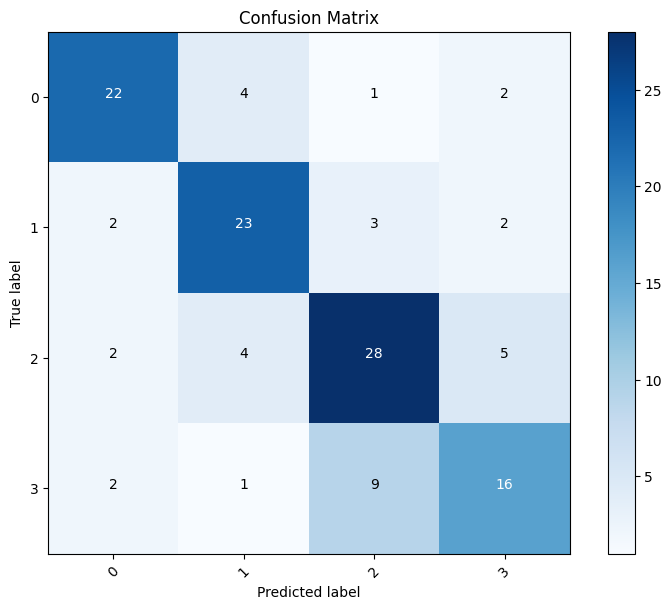

In [36]:
classes = [0, 1, 2, 3]  # Replace with your class labels
plot_confusion_matrix(confusion_matrix, classes)
plt.show()